In [2]:
# 1. import module

import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pycaret.regression import *

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = None

from itertools import product

from py_module.load_data import load_data
from py_module.plot_data import plot_histogram
from py_module.regression import *


from py_module.pre_processing import *
from py_module.verify import *
from py_module.etc import *
from py_module.compare import *
import warnings, logging, sys
warnings.simplefilter(action='ignore', category=FutureWarning)     # pandas 등
logging.getLogger().handlers.clear()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

import logging, sys, warnings, pandas as pd

# ① logging 핸들러 리셋
logging.getLogger().handlers.clear()
logging.basicConfig(stream=sys.stdout, level=logging.INFO, force=True)

# ② pandas SettingWithCopyWarning 무시 (원인 해결 후에도 잔여 경고 차단용)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

import joblib


In [244]:
def get_outlier(df=None, column=None, weight=1.5):
    
    # column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    data = df[column]
    quantile_25 = np.percentile(data.values,10)  # 1/4 분위
    quantile_75 = np.percentile(data.values,90)  # 3/4 분위
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight  # 이상치 최소 기준
    highest_val = quantile_75 + iqr_weight # 이상치 최대 기준
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = data[(data < lowest_val) | (data > highest_val)].index
    
    return outlier_index

def outlier_remove(data) :
    col_input = list(data.columns)[:-2]
    col_input = list(data.columns)

    # outlier 탐색 및 제거
    outlier_index = {}
    for i, colName in enumerate(col_input):
        outlier_index[i] = get_outlier(df=data, column=f'{colName}', weight=1.5)
    outlier_index

    # 각각의 숫자들 리스트 안에 넣기
    outlier_list = []
    for i in range(len(outlier_index)):
        if list(outlier_index[i].values) == []:
            continue
        outlier_list.append(list(outlier_index[i].values))


    # 리스트 안의 리스트들을 하나로 합치기
    outlier_list = sum(outlier_list , [])
    print('개수:', len(outlier_list))

    # 중복 숫자 제거
    outlier_list = set(outlier_list)
    print('개수:', len(outlier_list))

    # 다시 리스트 타입으로 변환
    outlier_list = list(outlier_list)
    print(type(outlier_list))

    # 리스트 숫자 정렬
    outlier_list.sort()

    # outlier를 갖는 index에 해당하는 data drop
    for i in outlier_list:
        data.drop(i, axis=0, inplace=True)

    print(f'필터링 후 : {data.shape}')

    return data

def train_model(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=765
    )

    param_grid = {
        "n_estimators": [500, 1000, 2000, 3000, 5000],
        "learning_rate": [0.01, 0.05, 0.1, 0.15],
        "num_leaves": [3, 7, 11, 15],
    }

    best_model = None
    best_r2 = float("-inf")
    best_params = None

    for n_est, lr, n_leaf in product(
        param_grid["n_estimators"],
        param_grid["learning_rate"],
        param_grid["num_leaves"]
    ):
        model = LGBMRegressor(
            random_state=765,
            n_estimators=n_est,
            learning_rate=lr,
            num_leaves=n_leaf,
            max_depth=-1,
            objective="poisson",
            boosting_type="dart",
        )
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        r2 = r2_score(Y_test, preds)

        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_params = {
                "n_estimators": n_est,
                "learning_rate": lr,
                "num_leaves": n_leaf,
            }

    print(f"Best R2: {best_r2:.6f} with params: {best_params}")
    return best_model, best_r2

def train_model_v2(X,Y) :

    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 765)

    Z = pd.concat([X_train,Y_train],axis=1)


    param_grid = {
        "n_estimators": [500, 1000, 2000, 3000],
        "learning_rate": [0.01, 0.05, 0.1, 0.15],
        "num_leaves": [3, 7, 11, 15],
    }

    best_model = None
    best_r2 = float("-inf")
    best_params = None

    for n_est, lr, n_leaf in product(
        param_grid["n_estimators"],
        param_grid["learning_rate"],
        param_grid["num_leaves"]
    ):
        model = LGBMRegressor(
            random_state=765,
            n_estimators=n_est,
            learning_rate=lr,
            num_leaves=n_leaf,
            max_depth=-1,
            objective="poisson",
            boosting_type="gbdt",
        )
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        r2 = r2_score(Y_test, preds)

        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_params = {
                "n_estimators": n_est,
                "learning_rate": lr,
                "num_leaves": n_leaf,
            }

    print(f"Best R2: {best_r2:.6f} with params: {best_params}")    

    return model, X_train,X_test,Y_train,Y_test

def train_model_v3(X,Y) :

    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 765)

    Z = pd.concat([X_train,Y_train],axis=1)

    model = LGBMRegressor(
            random_state=765,
            n_estimators=2000,
            learning_rate=0.1,
            num_leaves=15,
            max_depth=-1,
            objective="poisson",
            boosting_type="gbdt",
        )
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    r2 = r2_score(Y_test, preds)


    return model, X_train,X_test,Y_train,Y_test

In [203]:
column_names =  ["freq","input_voltage","w1","l1_leg","l1_top","l2","h1","l1_center",
                "Tx_turns","Tx_width","Tx_height","Tx_space_x","Tx_space_y","Tx_preg",
                "Rx_width","Rx_height","Rx_space_x","Rx_space_y","Rx_preg","g2",
                "Tx_layer_space_x","Tx_layer_space_y","wire_diameter","strand_number","Tx_current",
                "Ltx","Lrx1","Lrx2","M1","M2","k1","k2","Lmt","Lmr1","Lmr2",
                "Llt","Llr1","Llr2","Rtx","Rrx1","Rrx2",
                "Rx_current_optimetric","copperloss_Tx","copperloss_Rx1","copperloss_Rx2",
                "magnetizing_current_optimetric","coreloss","B_core","B_left","B_right","B_center","B_top_left","B_bottom_left","B_top_right","B_bottom_right",
                "magnetizing_copperloss_Tx","magnetizing_copperloss_Rx1","magnetizing_copperloss_Rx2"]
raw_data =  pd.read_csv("output_data.csv",delimiter=",",names=column_names,header=None,skiprows=1)

raw_data.head()
cols = ['M1', 'M2', 'k1', 'k2']
raw_data[cols] = raw_data[cols].apply(pd.to_numeric, errors='coerce').abs()

# '(width_ratio)*l2*ratio/({math.ceil(pri_turns/2)})
# 2. one-click
# Inputs specified by user: treat these as features; others as targets
input_cols_copper = ["freq","w1","l1_leg","l1_top","l2","h1","l1_center",
                "Tx_turns","Tx_width","Tx_height","Tx_space_x","Tx_space_y","Tx_preg",
                "Rx_width","Rx_height","Rx_space_x","Rx_space_y","Rx_preg","g2",
                "Tx_layer_space_x","Tx_layer_space_y","wire_diameter","strand_number",
                "Tx_current", "Rx_current_optimetric"]

input_cols_Lmt = ["freq","w1","l1_leg","l1_top","l2","h1","l1_center",
                "Tx_turns","Tx_width","Tx_height","Tx_space_x","Tx_space_y","Tx_preg",
                "Rx_width","Rx_height","Rx_space_x","Rx_space_y","Rx_preg","g2",
                "Tx_layer_space_x","Tx_layer_space_y","wire_diameter","strand_number"]

input_cols_core = ["freq","w1","l1_leg","l1_top","l2","h1","l1_center",
                "Tx_turns","Tx_width","Tx_height","Tx_space_x","Tx_space_y","Tx_preg",
                "Rx_width","Rx_height","Rx_space_x","Rx_space_y","Rx_preg","g2",
                "Tx_layer_space_x","Tx_layer_space_y","wire_diameter","strand_number",
                "magnetizing_current_optimetric"]

output_cols_first = ["Lmt","Llt","Llr1","Llr2","copperloss_Tx","copperloss_Rx1","copperloss_Rx2"]
output_cols_core = ["coreloss","B_core","B_left","B_center","B_top_left","magnetizing_copperloss_Tx","magnetizing_copperloss_Rx1","magnetizing_copperloss_Rx2"]


pd_data = raw_data.dropna(axis=0,how='any')

pd_data = outlier_remove(pd_data)

pd_data = pd_data[(pd_data["B_left"] >= 0.01)]
pd_data = pd_data.dropna()

# Finalize inputs by intersecting with available columns
input_cols = [c for c in input_cols_copper if c in pd_data.columns]
print(f"Using {len(input_cols)}/{len(input_cols)} provided input columns")
input_Lmt = [c for c in input_cols_Lmt if c in pd_data.columns]
input_core = [c for c in input_cols_core if c in pd_data.columns]


개수: 12911
개수: 3008
<class 'list'>
필터링 후 : (12317, 58)
Using 25/25 provided input columns


In [176]:
# Outputs: anything not in input_cols
TARGETS = [c for c in pd_data.columns if c in output_cols_first]

date = time.strftime("%y%m%d")
r2_scores = []

for i in TARGETS :
    X = pd_data[input_cols].copy()
    Y = pd_data[i].copy()
    model, r2_s= train_model(X,Y)
    r2_scores.append({"target": i, "r2": r2_s})
    joblib.dump(model, f'./model/{i}_{date}.pkl')

print(r2_scores)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1895
[LightGBM] [Info] Number of data points in the train set: 10596, number of used features: 24
[LightGBM] [Info] Start training from score 4.300346
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1895
[LightGBM] [Info] Number of data points in the train set: 10596, number of used features: 24
[LightGBM] [Info] Start training from score 4.300346
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1895
[LightGBM] [Info] Number of data points in the train set: 10596, number of used features: 24
[LightGBM] [Info] Start tra

In [179]:
# Outputs: anything not in input_cols
TARGETS = [c for c in pd_data.columns if c in output_cols_core]

date = time.strftime("%y%m%d")
r2_core_scores=[]
for i in TARGETS :
    X = pd_data[input_core].copy()
    Y = pd_data[i].copy()
    model, r2_s= train_model(X,Y)
    r2_core_scores.append({"target": i, "r2": r2_s})
    joblib.dump(model, f'./model/{i}_{date}.pkl')

print(r2_core_scores)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2033
[LightGBM] [Info] Number of data points in the train set: 10596, number of used features: 24
[LightGBM] [Info] Start training from score 4.133674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2033
[LightGBM] [Info] Number of data points in the train set: 10596, number of used features: 24
[LightGBM] [Info] Start training from score 4.133674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2033
[LightGBM] [Info] Number of data points in the train set: 10596, number of used features: 24
[LightGBM] [Info] Start tra

KeyboardInterrupt: 

In [247]:

param = "magnetizing_copperloss_Tx"
X = pd_data[input_core].copy()
Y = pd_data[param].copy()
date = time.strftime("%y%m%d")
date = 251027
model,X_train,X_test,Y_train,Y_test= train_model_v3(X,Y)
joblib.dump(model, f'./model/{param}_{date}.pkl')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2022
[LightGBM] [Info] Number of data points in the train set: 9298, number of used features: 24
[LightGBM] [Info] Start training from score 3.475634


['./model/magnetizing_copperloss_Tx_251027.pkl']

array([  0.94694056,   4.07452828, 291.11781672,  17.06217503,
        12.1545454 ])

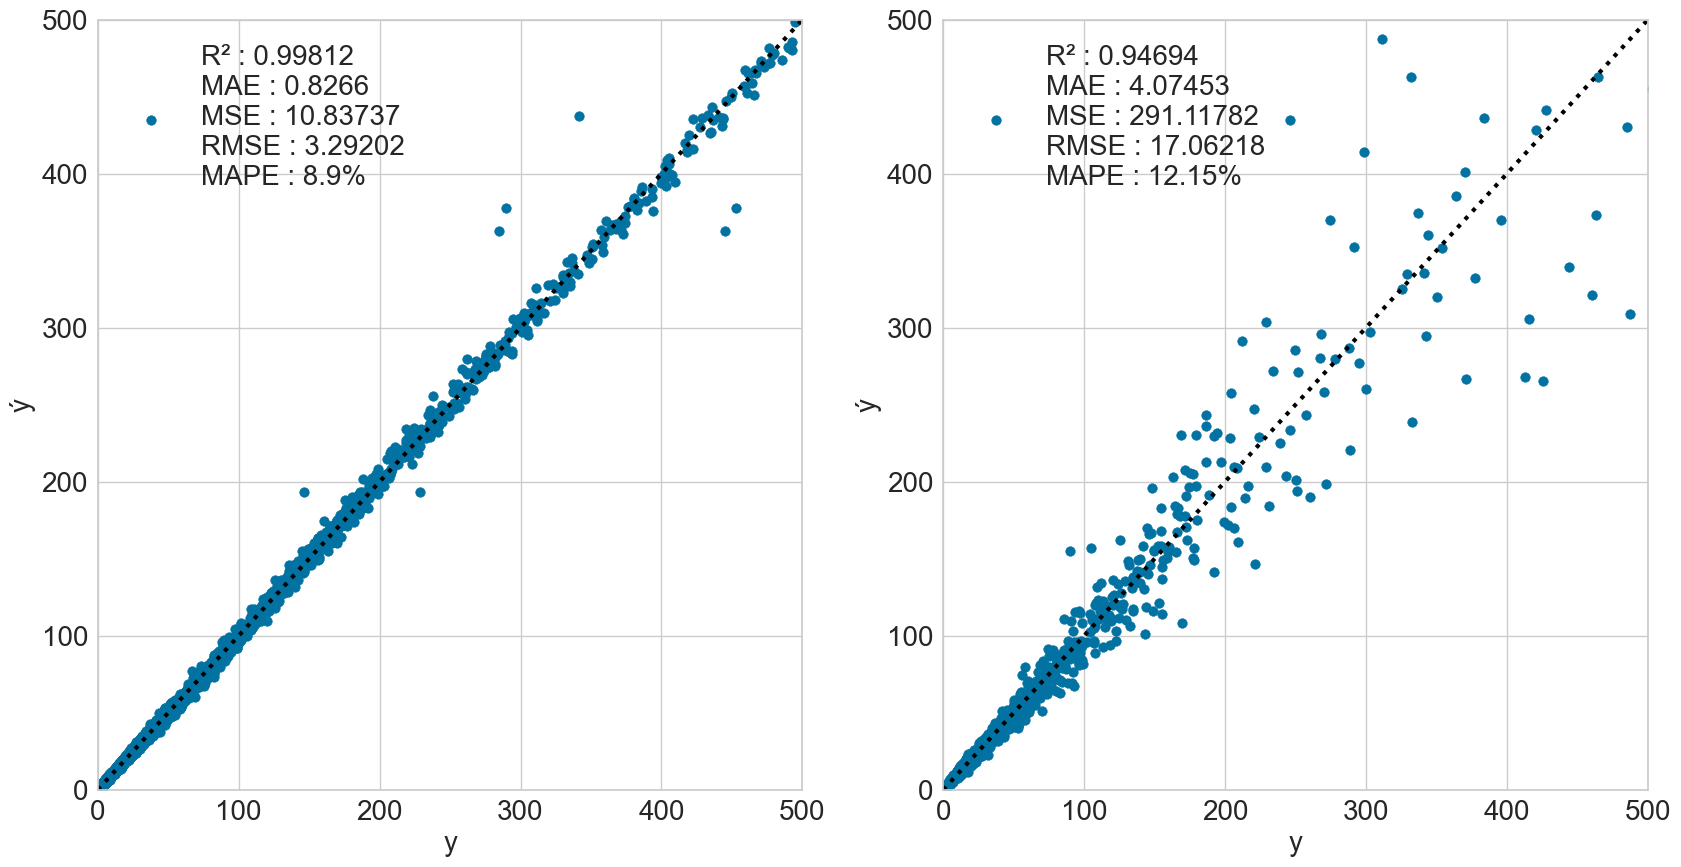

In [246]:
train_data = pd.concat([X_train,pd.DataFrame(Y_train)], axis=1)

test_data = pd.concat([X_test,pd.DataFrame(Y_test)], axis=1)


train_data.head()


verify_plot(model, train_data, test_data, param, xlim=[0,500], ylim=[0,500], legend=True, x_txt="", y_txt="")




In [196]:
temp = model.predict(X_test)

X_test_reset = X_test.reset_index(drop=True)
Y_test_reset = Y_test.reset_index(drop=True)

# 새로운 데이터프레임 temp2와 concat 시도

result = pd.concat([X_test_reset,Y_test_reset, pd.DataFrame(temp)],axis=1)
result_sorted = result.sort_values(by=param, ascending=True)
result_sorted.head(1000)

,freq,w1,l1_leg,l1_top,l2,h1,l1_center,Tx_turns,Tx_width,Tx_height,Tx_space_x,Tx_space_y,Tx_preg,Rx_width,Rx_height,Rx_space_x,Rx_space_y,Rx_preg,g2,Tx_layer_space_x,Tx_layer_space_y,wire_diameter,strand_number,magnetizing_current_optimetric,magnetizing_copperloss_Tx,0
1854,400.0,61.0,4.4,0.5,28.6,2.36,18.0,12.0,0.56,0.56,0.3,4.7,0.29,4.5,0.140,4.7,3.5,0.16,0.18,1.6,0.5,0.06,43.0,0.0311,0.00033,0.079520
2305,310.0,32.0,14.9,1.5,28.7,2.85,17.0,13.0,0.43,0.43,1.6,4.7,0.12,6.9,0.140,2.8,1.9,0.06,0.11,3.2,0.8,0.07,19.0,0.0440,0.00062,0.051892
472,400.0,61.0,4.4,0.5,28.6,2.36,18.0,12.0,0.56,0.56,0.3,4.7,0.29,4.5,0.140,4.7,3.5,0.16,0.18,1.6,0.5,0.06,43.0,0.0622,0.00131,0.079520
720,280.0,46.0,11.3,1.7,29.3,2.40,15.0,12.0,0.60,0.60,3.1,0.8,0.24,9.0,0.070,3.9,0.3,0.11,0.20,0.9,1.0,0.05,73.0,0.0755,0.00148,0.054277
1877,310.0,118.0,11.1,1.4,28.9,2.67,14.0,4.0,0.81,0.81,2.0,2.7,0.08,17.8,0.070,3.1,0.4,0.19,0.21,3.7,1.0,0.07,67.0,0.2004,0.00198,0.014569
347,290.0,82.0,2.8,1.0,22.3,2.43,15.0,12.0,0.38,0.38,3.4,3.2,0.13,5.5,0.105,3.9,3.6,0.17,0.51,4.1,0.4,0.07,15.0,0.0598,0.00226,0.081496
1227,290.0,46.0,8.8,2.0,28.8,2.83,18.0,10.0,0.75,0.75,1.2,1.3,0.13,9.7,0.070,4.7,1.9,0.19,0.35,1.2,0.6,0.06,79.0,0.0960,0.00232,0.039017
849,200.0,40.0,9.9,1.1,30.0,2.32,22.0,7.0,0.52,0.52,0.1,1.9,0.13,4.4,0.105,0.3,0.2,0.13,0.15,2.8,2.6,0.08,21.0,0.1633,0.00277,0.022057
31,240.0,174.0,4.8,1.8,21.5,2.62,25.0,5.0,0.54,0.54,2.9,2.2,0.12,10.2,0.105,4.0,1.4,0.24,1.10,1.3,0.3,0.06,41.0,0.1550,0.00343,0.026215
1580,195.0,95.0,10.3,1.2,24.7,2.23,24.0,10.0,0.54,0.54,3.6,2.2,0.07,4.2,0.175,4.1,3.2,0.19,0.23,2.9,0.4,0.05,59.0,0.0984,0.00381,0.071713


In [160]:
X = [list(map(float, "350 66 10.6 2 20.6 2.8 7 6 0.65 0.65 2.4 1.6 0.11 4 0.14 1 2.4 0.07 0.98 1.4 0.2 0.08 33".split()))]


Lmt_model = joblib.load("model\\Lmt_251027.pkl")
Lmt_model.predict(X)

array([27.72365303])